## **0. Setting**

In [13]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # 한글 깨짐 방지
    !sudo apt-get install -y fonts-nanum 
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

In [ ]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

In [12]:
# package import
import os
import glob
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.utils import shuffle

import keras
import tensorflow as tf

from keras import layers, regularizers
from keras.models import Sequential, save_model
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16

import tensorflow.keras.utils as Utils
from tensorflow.keras.optimizers import Adam

# 변수 저장
DIR_NAME = '/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Project/Image'
query = '/*/*/*.jpg'
SEED = 42

# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

## **1. Read Image & Data Handling**

In [ ]:
# 파일 경로 서치
train_file_paths = glob.glob(DIR_NAME + query)

# 랜드마크 갯수 확인
classes = list(set([train_file_paths[i].split('/')[-2] for i in range(len(train_file_paths))]))

print(f"Total num of data: {len(train_file_paths)}")
print(f"Total num of classes: {len(classes)}")

In [ ]:
# 분석에 필요한 정보 추출 (파일 명, 랜드마크 id, 파일 경로)
def generate_dict(file_paths, classes):
    landmark_ids = []
    ids = []
    path = []
    for i in range(len(file_paths)):
        try:
            landmark_ids.append(classes.index(file_paths[i].split('/')[-2]))
            ids.append(file_paths[i].split('/')[-1][:-4])
            path.append(file_paths[i])
        except:
            pass

    gen_dict = {'id': ids,
             'landmark_id': landmark_ids,
             'path': path}   
    return gen_dict

train_df = generate_dict(train_file_paths, classes)
train_df = pd.DataFrame(train_df)
train_df.head()

## **2. Image Resize**

In [ ]:
def resize_image_file(file_names, save_path, train=True):
    for i in range(len(file_names)):
        img = cv2.imread(file_names[i])
        img = cv2.resize(img, (384 ,384))
        if train:
          # 이미지를 저장할 경로가 없다면 새로 만들기
            try:
                if not(os.path.isdir(save_path + 'train/' + file_names[i].split('/')[-2])):
                    os.makedirs(os.path.join(save_path + 'train/' + file_names[i].split('/')[-2]))
            except:
                print("Failed to create train directory!!!!!")
          
          # 이미지 중복 저장 방지
            if not(os.path.isfile(save_path + 'train/' + file_names[i].split('/')[-2] + '/' + os.path.splitext(file_names[i].split('/')[-1])[0] + '.jpg')):                    
                    cv2.imwrite(os.path.join(save_path + 'train/' + file_names[i].split('/')[-2] + '/' + os.path.splitext(file_names[i].split('/')[-1])[0] + '.jpg'), img)
            else:
                pass

In [ ]:
# 경로 설정
save_path = DIR_NAME + "/resize"

# Image Resizing
resize_image_file(train_file_paths, save_path, train=True)

## **3. Import Resized Image**

In [5]:
labels_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5,
              'g':6, 'h':7, 'i':8, 'j':9, 'k':10,
              'l':11, 'm':12, 'n':13, 'o':14, 'p':15,
              'q':16, 'r':17, 's':18, 't':19, 'u':20,
              'v':21, 'w':22, 'x':23, 'y':24, 'z':25,
              'z_a':26, 'z_b':27, 'z_c':28, 'z_d':29, 'z_e':30,
              'z_f':31, 'z_g':32, 'z_h':33, 'z_i':34, 'z_j':35,
              'z_k':36, 'z_l':37, 'z_m':38, 'z_n':39, 'z_o':40}

def get_images(directory):
    Images = []
    Labels = []
    label = 0

    for labels in os.listdir(directory):
          label = labels_dict[labels]

          for image_file in os.listdir(directory+labels):
              image = cv2.imread(directory+labels+r'/'+image_file)
              image = cv2.resize(image,(150, 150))
              Images.append(image)
              Labels.append(label)
    
    return shuffle(Images, Labels, random_state=SEED)

def get_classlabel(class_code):
    labels = {0:'5D입체영상관', 1:'남구국민체육센터', 2:'뉴코아아울렛울산점', 3:'대현체육관', 4:'동구국민체육센터', 5:'매곡산업단지',
              6:'명촌어린이도서관', 7:'문수국제양궁장', 8:'문수힐링피크닉장', 9:'북구청소년문화의집', 10:'석계서원',
              11:'농소1동도서관', 12:'롯데백화점울산점', 13:'문수월드컵경기장', 14:'성남청소년문화의집', 15:'세이브존울산점',
              16:'꽃바위문화관', 17:'덕신1차시장', 18:'도로교통공단', 19:'목련암', 20:'문수야구장',
              21:'동구평생학습관', 22:'박제상유적', 23:'언양알프스시장', 24:'언양종합상가시장', 25:'옥골시장',
              26:'남구문화원', 27:'동축사', 28:'등억온천단지', 29:'롯데마트진장점', 30:'박상진의사송정역사공원',
              31:'곰장어골목', 32:'국립재난안전연구원', 33:'롯데마트울산점', 34:'만정헌', 35:'삼일사',
              36:'성남프라자', 37:'야음상가시장', 38:'약사동제방유적전시관', 39:'에너지경제연구원', 40:'옥골샘도서관'}
    
    return labels[class_code]

In [16]:
# 리사이징된 이미지 가져오기 - train
Images, Labels = get_images(DIR_NAME + '/train/')
Images = np.array(Images)
Labels = np.array(Labels)
Images = Images / 255.0

# 리사이징된 이미지 가져오기 - test
pred_images, no_labels = get_images(DIR_NAME + '/test/')
pred_images = np.array(pred_images)
pred_images = pred_images / 255.0

# 결과 확인 - data shape
print("Shape of Train Images:", Images.shape)
print("Shape of Labels:", Labels.shape)
print("Shape of Classes:", len(set(Labels)))
print("Shape of Test Images:", pred_images.shape)

Shape of Train Images: (7694, 150, 150, 3)
Shape of Labels: (7694,)
Shape of Classes: 41
Shape of Test Images: (837, 150, 150, 3)


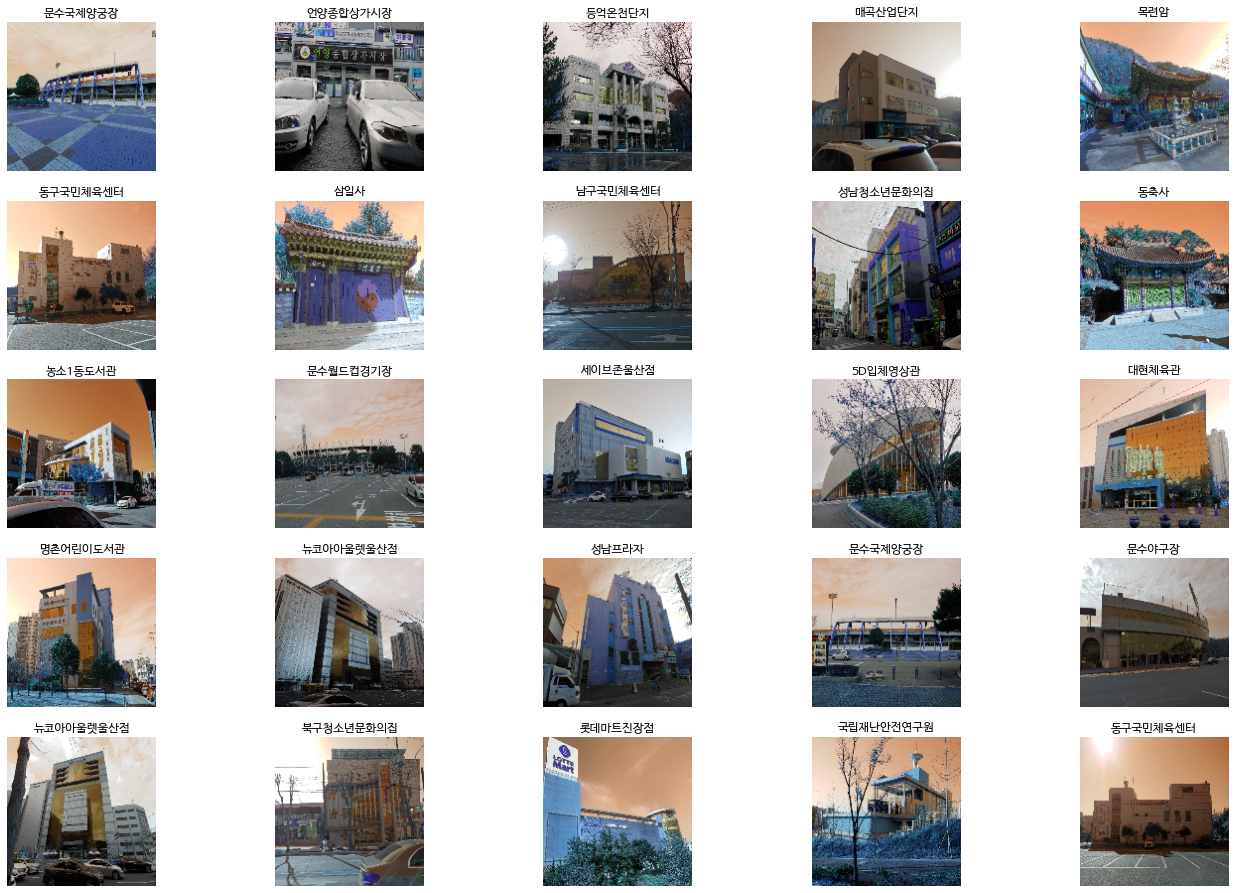

In [7]:
# 결과 확인 - Visualization
plt.rc('font', family='NanumBarunGothic') 
plt.rc('axes', unicode_minus=False)

f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = random.randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

## **4. Model Setting**

In [8]:
# early stopping
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 5,
                               mode = 'auto')

# load base model
base_model = VGG16(
    weights = '/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Project/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top = False, 
    input_shape = (150, 150, 3))

In [9]:
# model setting & compile
tf.random.set_seed(2)

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512,
                       # input_shape = (150, 150, 3),
                       activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256,
                       activation = 'relu'))
model.add(layers.Dense(128,
                       activation = 'relu',
                       kernel_regularizer = regularizers.l2(0.00001),
                       activity_regularizer = regularizers.l1(0.00001)))
model.add(layers.Dense(41,
                       activation = 'softmax'))

model.layers[0].trainable = False

model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = [keras.metrics.SparseCategoricalAccuracy(name = "accuracy"),
                       keras.metrics.SparseTopKCategoricalAccuracy(3, name = "top3_acc"),
                       keras.metrics.SparseTopKCategoricalAccuracy(5, name = "top5_acc")])

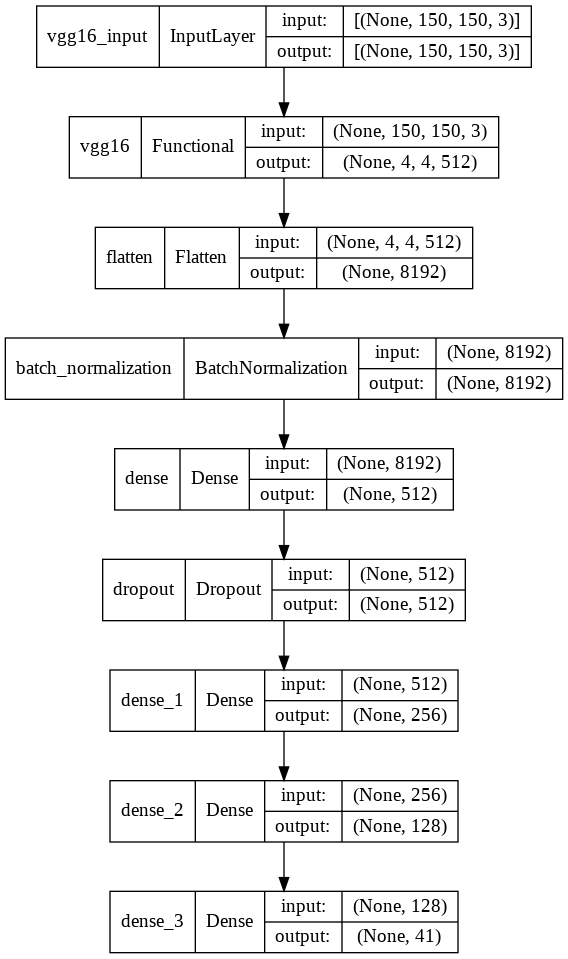

In [13]:
# model summary
# model.summary()
Utils.plot_model(model, to_file = 'model.png', show_shapes = True)

In [10]:
# model training
history = model.fit(Images,
                    Labels,
                    epochs = 1000,
                    validation_split = 0.20,
                    callbacks = [early_stopping])

Epoch 1/1000
193/193 [==============================] - 13s 52ms/step - loss: 0.9661 - accuracy: 0.8239 - top3_acc: 0.8767 - top5_acc: 0.9001 - val_loss: 0.3562 - val_accuracy: 0.9916 - val_top3_acc: 0.9968 - val_top5_acc: 0.9994
Epoch 2/1000
193/193 [==============================] - 9s 44ms/step - loss: 0.0282 - accuracy: 0.9994 - top3_acc: 0.9997 - top5_acc: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9968 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 3/1000
193/193 [==============================] - 9s 45ms/step - loss: 0.0107 - accuracy: 1.0000 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.0175 - val_accuracy: 0.9968 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 4/1000
193/193 [==============================] - 8s 44ms/step - loss: 0.0076 - accuracy: 1.0000 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.0165 - val_accuracy: 0.9961 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 5/1000
193/193 [==============================] - 8s 44ms/step - loss: 0.0065

## **5. Training Result**

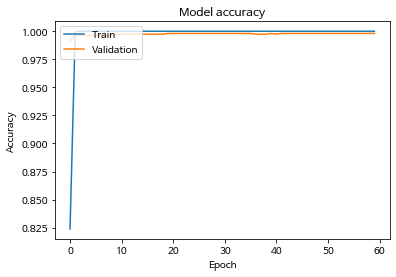

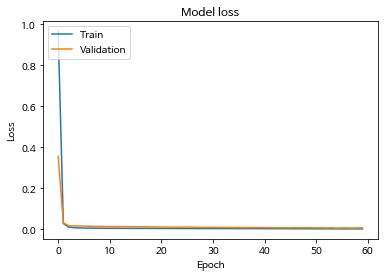

In [20]:
# Training Result Visualization
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

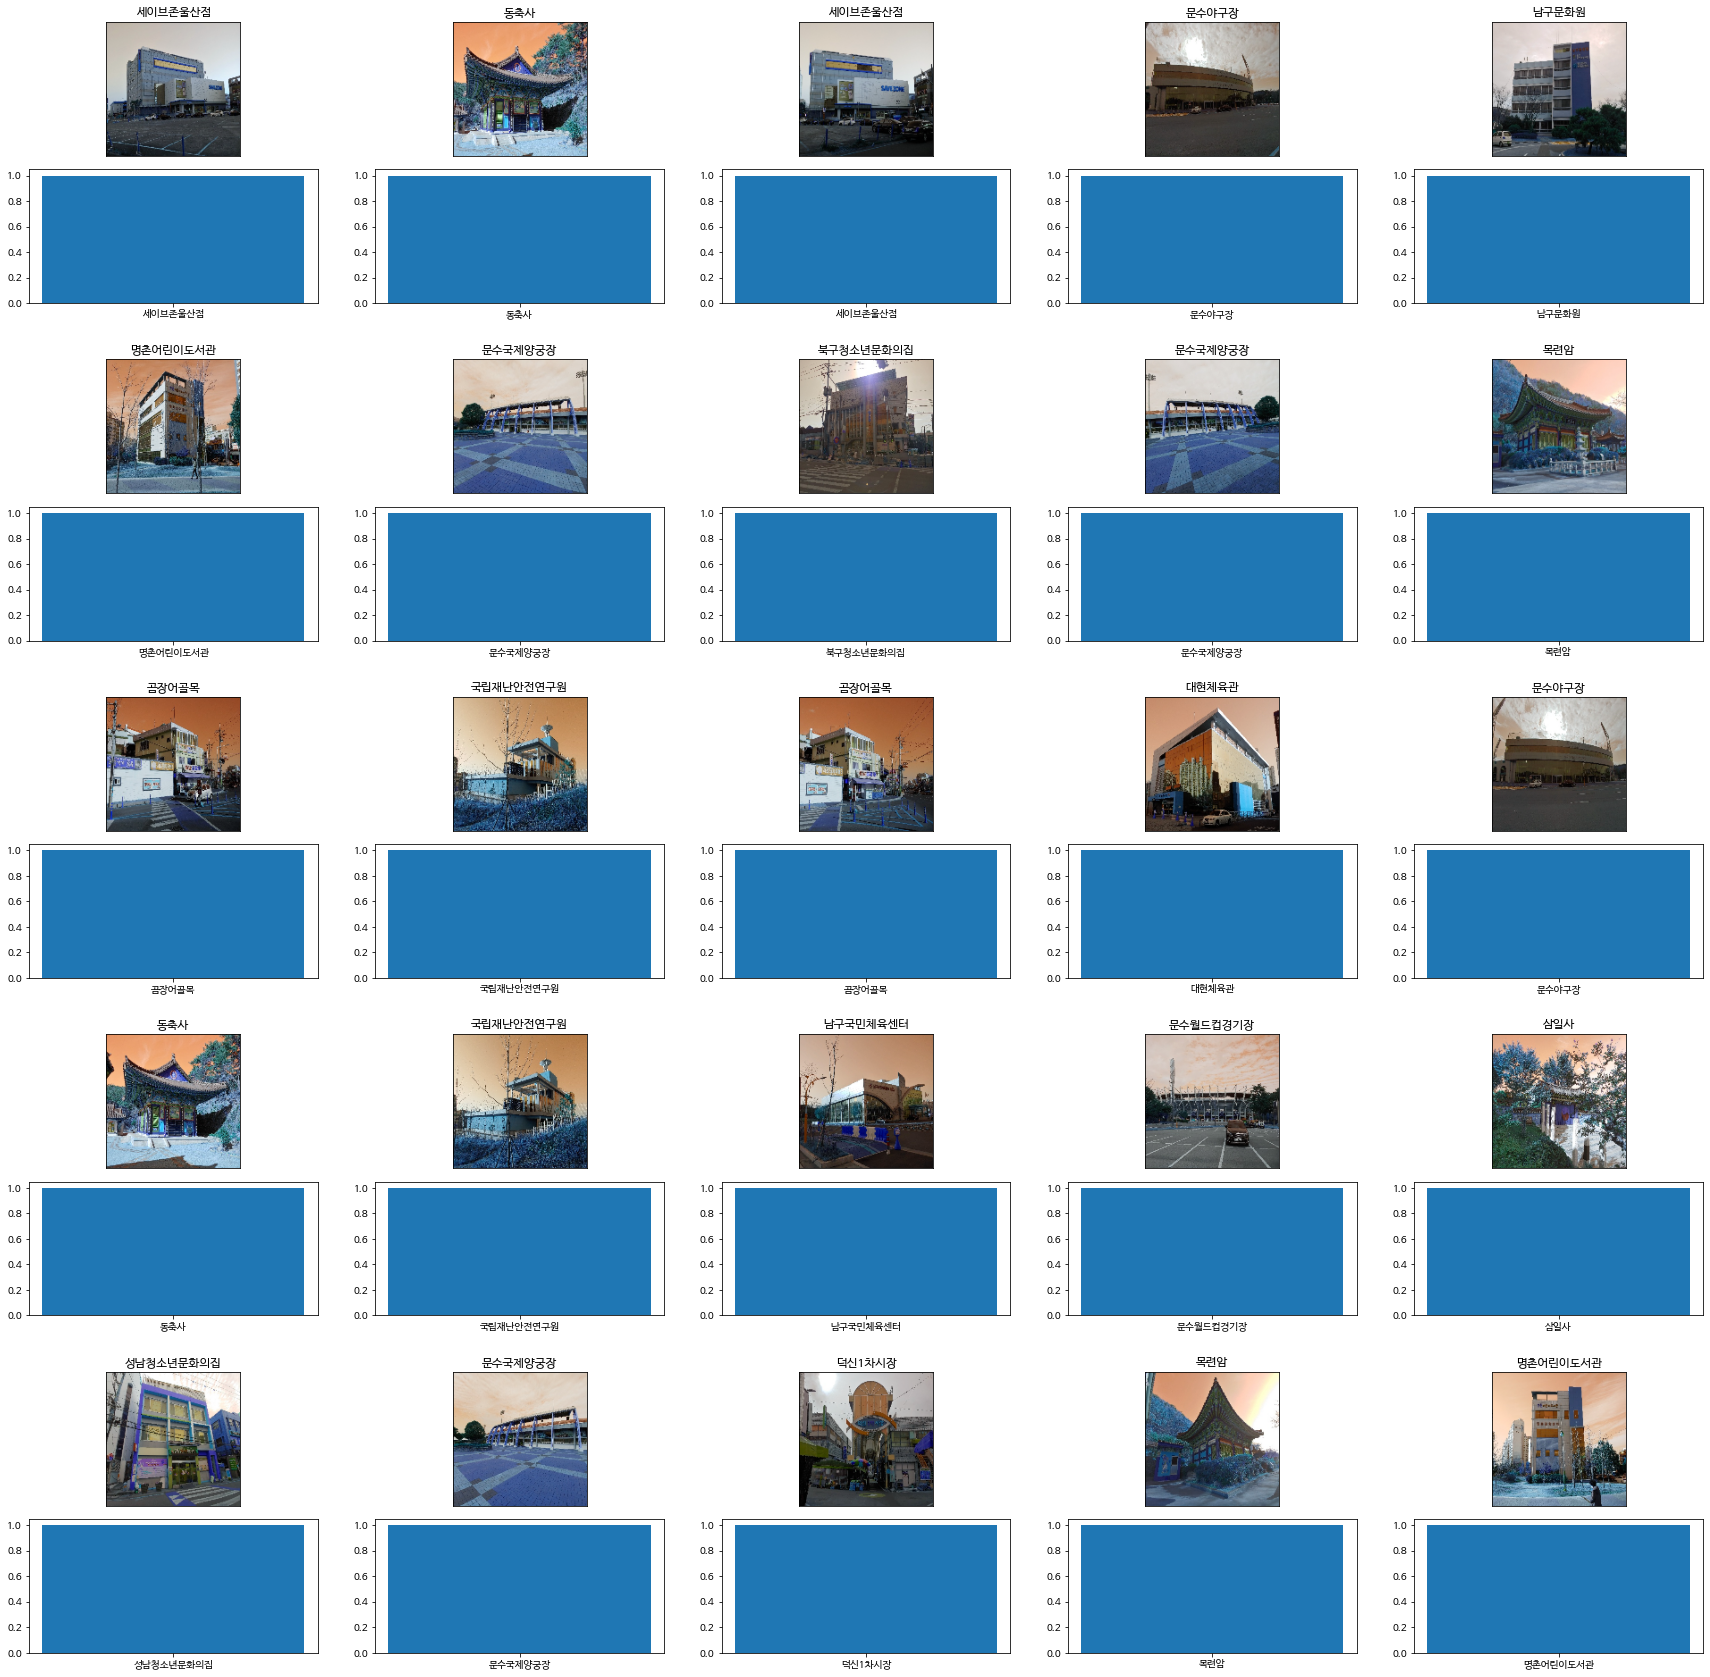

In [18]:
# Test Data result
fig = plt.figure(figsize = (30, 30))
outer = gridspec.GridSpec(5, 5, wspace = 0.2, hspace = 0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[i], wspace = 0.1, hspace = 0.1)
    rnd_number = random.randint(0, len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_prob = model.predict(pred_image)[0]
    pred_class = get_classlabel(np.argmax(pred_prob))
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar(pred_class, pred_prob, width=0.1)
            fig.add_subplot(ax)

## **6. Save Model**

In [21]:
# 모델 저장
save_model(model = model,
           filepath = '/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Project/model.h5',
           overwrite = True,
           include_optimizer = True)

In [ ]:
# 분석 환경 저장
!pip freeze > requirements.txt